# JMAデータセットによるデータ拡張のテスト

In [44]:
import numpy as np
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms

import pandas as pd
import h5py
import os
import sys
import json
import time

In [45]:
# -----------------------------
# add "src" as import path
path = os.path.join('../src')
sys.path.append(path)

from jma_pytorch_dataset import *

In [46]:
data_path = "../data/data_kanto_aug/"
train_path = "../data/filelist_triplet_train_JMARadar_nozero.csv"
tdim_use = 12

In [47]:
train_dataset = JMARadarDataset3(root_dir=data_path,
                                            csv_file=train_path,
                                            tdim_use=tdim_use,
                                            randinit=True,
                                            transform=None)

In [48]:
batch_size = 10
n_threads = 4

In [49]:
 train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                   num_workers=n_threads,
                                                   drop_last=True,
                                                   shuffle=True)

In [50]:
dd = next(iter(train_dataset))

In [51]:
type(dd)

dict

In [52]:
dd['fnames_past']

'2p-jmaradar5_2015-01-01_0000utc.h5'

In [54]:
type(dd['past'])

numpy.ndarray

## Data Augmentation

In [108]:
transforms.RandomRotation(degrees=30)

RandomRotation(degrees=(-30, 30), resample=False, expand=False)

In [239]:
from scipy.ndimage.interpolation import rotate,zoom

In [240]:
import matplotlib.pyplot as plt

In [284]:
class RandomRotateVideo(object):
    """RandomRotate for Video Data

    Args:
        degrees (float): Rotation Angle
    """
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, sample):
        past, future = sample['past'], sample['future']
        degree = (np.random.rand()-0.5)*self.degrees*2
        past= rotate(past,degree,axes=(2,3),reshape=False)
        future= rotate(future,degree,axes=(2,3),reshape=False)
        return {'past': past, 'future': future}

In [285]:
class RandomResizeVideo(object):
    """RandomRotate for Video Data

    Args:
        degrees (float): Rotation Angle
    """
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, sample):
        past, future = sample['past'], sample['future']
        size1,size2 = past.shape[2],past.shape[3]
        z1 = 1 + np.random.rand()*self.factor
        z2 = 1 + np.random.rand()*self.factor
        #print("z1,z2=",z1,z2)
        past= zoom(past,zoom=[1,1,z1,z2])
        future= zoom(future,zoom=[1,1,z1,z2])
        past= past[:,:,0:size1,0:size2]
        future= future[:,:,0:size1,0:size2]
        return {'past': past, 'future': future}

In [286]:
Rot = RandomRotateVideo(degrees=0)
Resize = RandomResizeVideo(factor=0.1)

In [287]:
composed = transforms.Compose([Rot,Resize])

In [288]:
train_dataset = JMARadarDataset3(root_dir=data_path,
                                            csv_file=train_path,
                                            tdim_use=tdim_use,
                                            randinit=False,
                                            transform=None)

In [289]:
dd = next(iter(train_dataset))
print('past filename:',dd["fnames_past"])
rain = dd['past'][:,0,:,:]

past filename: 2p-jmaradar5_2015-01-01_0000utc.h5


In [290]:
np.max(rain)

6.75

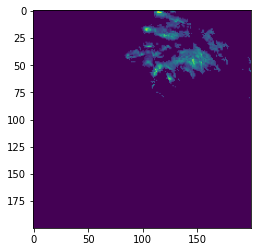

In [291]:
plt.imshow(dd['past'][0,0,:,:])

In [297]:
Rot = RandomRotateVideo(degrees=0)
Resize = RandomResizeVideo(factor=0.3)
composed = transforms.Compose([Rot,Resize])
train_dataset = JMARadarDataset3(root_dir=data_path,
                                            csv_file=train_path,
                                            tdim_use=tdim_use,
                                            randinit=False,
                                            transform=composed)

In [298]:
dd = next(iter(train_dataset))
#print('past filename:',dd["fnames_past"])
rain = dd['past'][:,0,:,:]

z1,z2= 1.0109528238044916 1.052977622880658


In [299]:
rain.shape

(12, 200, 200)

In [300]:
np.max(rain)

6.175102

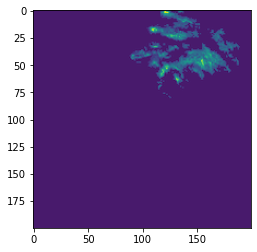

In [301]:
plt.imshow(dd['past'][0,0,:,:])

In [105]:
h5_name_X = "../data/data_kanto_aug/2p-jmaradar5_2015-01-01_0000utc.h5"
h5file = h5py.File(h5_name_X,'r')
rain_X = h5file['R'][()]
#rain_X = np.maximum(rain_X,0) # replace negative value with 0
#rain_X = rain_X[-self.tdim_use:,None,:,:] # add "channel" dimension as 1

In [106]:
np.max(rain_X)

41.5

In [107]:
rain_X.shape

(12, 400, 400)